install the package

In [1]:
!pip install transformers

import the package

In [2]:
import os
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from transformers import VisionEncoderDecoderModel,ViTFeatureExtractor,AutoTokenizer
from google.colab.patches import cv2_imshow

print ("The version of cv2 is:", cv2. __version__)


The version of cv2 is: 4.8.0


connect to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


show the image

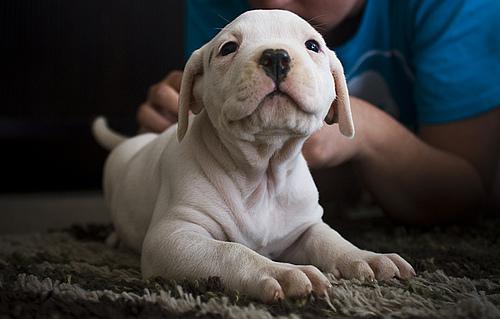

In [4]:
img = cv2.imread('/content/drive/MyDrive/dogs/dog_image02.jpg')
cv2_imshow(img)

scaling

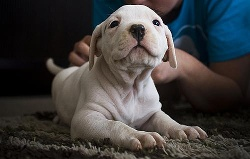

In [5]:
(height, width) = img.shape[:2]
res = cv2.resize(img, (int(width / 2), int(height / 2)), interpolation = cv2.INTER_CUBIC)
cv2.imwrite('result.jpg', res)
img1 = cv2.imread('result.jpg')
cv2_imshow(img1)
cv2.waitKey(0)
cv2.destroyAllWindows()


load the inception model

In [6]:
from tensorflow.keras.applications import InceptionV3


inception_model = InceptionV3(weights='imagenet', include_top=False)




87910968/87910968 [==============================] - 2s 0us/step


resizing the image

In [7]:
def load_img(img_path):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_jpeg(img,3)
  img = tf.keras.layers.Resizing(299,299)(img)
  img = img / 255.0
  return img

feature vectoring

In [8]:
def get_feature_vector(img_path):

  img = load_img(img_path)
  img = tf.expand_dims(img,0)
  feature_vector = inception_model.predict(img)
  return img,feature_vector

1/1 [==============================] - 4s 4s/step


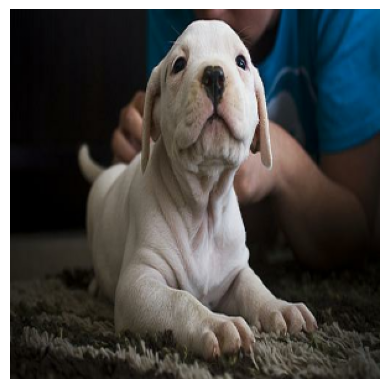


Input image size : (1, 299, 299, 3)
Feture vector size : (1, 8, 8, 2048)


In [9]:
img,feature_vector = get_feature_vector('/content/drive/MyDrive/dogs/dog_image02.jpg')
plt.imshow(np.squeeze(img, 0))
plt.axis('off')
plt.show()

print()
print('Input image size :',img.shape)
print('Feture vector size :',feature_vector.shape)


import the package

In [10]:
from transformers import ViTImageProcessor

train the model

In [11]:
model = VisionEncoderDecoderModel.from_pretrained('nlpconnect/vit-gpt2-image-captioning')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

In [12]:
feature_extractor = ViTFeatureExtractor.from_pretrained('nlpconnect/vit-gpt2-image-captioning')


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [13]:
tokenizer = AutoTokenizer.from_pretrained('nlpconnect/vit-gpt2-image-captioning')

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

loading the image,tokenizing,generate a caption

In [15]:
max_length = 16  # Using a more descriptive variable name
num_beams = 4

def predict_step(image_paths):


    images = []
    for image_path in image_paths:
        try:

            i_image = Image.open(image_path)
            if i_image.mode != 'RGB':
                i_image = i_image.convert(mode='RGB')
            images.append(i_image)
        except FileNotFoundError:
            print(f"Error: Image file not found at {image_path}")


    pixel_values = feature_extractor(images=images, return_tensors='pt').pixel_values
    pixel_values = pixel_values.to(device)

    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}


    output_all_intermediates = model.generate(pixel_values, **gen_kwargs)


    preds = tokenizer.batch_decode(output_all_intermediates, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]

    return preds

captions = predict_step(['/content/result.jpg'])

if captions:
    print("Generated captions:")
    for caption in captions:
        print(caption)
else:
    print("No captions generated.")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Generated captions:
a brown and white dog laying on the floor next to a person
